In [1]:
import numpy as np
import zarrPlotFunctions as zplt
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.dates import DateFormatter
import xarray as xr
import zarr
import s3fs
import boto3
import numcodecs as ncd
import cartopy
import cartopy.crs as ccrs 
import struct
import os

### Amazon Access Info

In [ ]:
REGION = 'us-west-1'
BUCKET = 'hrrrzarr'

levelVar = '/surface/GUST/surface/GUST/'


s3 = boto3.resource(
    service_name='s3',
    region_name=REGION,
    )

In [2]:
data = '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/hrrr/HRRR_latlon.h5'
x = xr.open_dataset(data)
lat = x.latitude.data
lon = x.longitude.data

In [3]:
ptLat = 44.9408
ptLon = -122.4008

x, y = zplt.findChunk(ptLat,ptLon)

chunkID = '0.{}.{}'.format(x,y)
# Analysis arrays are only 2D
chunkIDAnl = '{}.{}'.format(x,y)

newLats, newLons = zplt.getLatLons(x,y)

In [ ]:
# Set up dates
dates = []
DAY = []

# Set up hourly time stamps
start = datetime(2020, 9, 7, 12, 0)
end = start + timedelta(hours=54)

for times in zplt.perdelta(start, end, timedelta(hours=1)):
    DAY.append(datetime.strftime(times, '%Y%m%d'))
    dates.append(datetime.strftime(times, '%Y%m%d_%Hz'))

## Plot Analysis Time of Gust > 10 m/s
### Download Analyses for Spatial Plots

In [ ]:
tempFilePath = '/uufs/chpc.utah.edu/common/home/horel-group4/tmccorkle/hrrr_conus/anl_chunks/'
gust_anl = np.zeros((150,150))
gust_anl[:,:] = np.nan

for hr in range(0,54):
    '''
    fileName = dates[hr]+'_anl.zarr'
    fileKey = 'sfc/'+DAY[hr]+'/'+fileName+levelVar+chunkIDAnl
    filePath = tempFilePath+dates[hr]+'_chunk'
    s3.meta.client.download_file(BUCKET, fileKey, filePath)
    '''
    chunkPath = tempFilePath+dates[hr]+'_chunk'
    # Decompress the chunk you want
    buf = ncd.blosc.decompress(open(chunkPath, 'rb').read())

    chunk = np.frombuffer(buf, dtype='<f2')

    hrrrVar = np.reshape(chunk,((150,150)))
    hrrrArray = np.zeros((150,150))
    
    hrrrArray[:] = hrrrVar[:]
    hrrrArray[hrrrArray < 10] = 0.
    
    gust_anl[np.isnan(gust_anl) & (hrrrArray >= 10)] = int(hr)
    

### Spatial Plot of Analysis Times

In [ ]:
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt

fig = plt.figure(figsize=(10,11))
#ax = plt.axes(projection=ccrs.Mercator())
stamen_terrain = cimgt.Stamen('terrain-background')
ax = plt.axes(projection=stamen_terrain.crs)

figDir = '/uufs/chpc.utah.edu/common/home/u1014509/public_html/phd/zarr/'

ax.coastlines(linewidth=1.5)
ax.set_extent([-124.65,-119.98,42.1,45.9])
states = cartopy.feature.NaturalEarthFeature(
            category='cultural', scale='50m', facecolor='none',
            name='admin_1_states_provinces_shp')

roads = cartopy.feature.NaturalEarthFeature(
            category='cultural', scale='10m', facecolor='none',
            name='roads')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.bottom_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlocator = mticker.FixedLocator([-123,-121])
gl.ylocator = mticker.FixedLocator([43,45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 20, 'color': 'black'}
gl.xlabel_style = {'size': 20,'color': 'black'}

clevs = np.arange(0,42,3)
cmap = plt.cm.get_cmap('rainbow')
norm = mcolors.BoundaryNorm(clevs,cmap.N)



ax.add_image(stamen_terrain,8)
ax.add_feature(states,edgecolor='black',linewidth=1.5,zorder=98)
ax.add_feature(cartopy.feature.BORDERS,edgecolor='black',zorder=98)
ax.add_feature(roads,edgecolor='white',linewidth=1.5,zorder=98)

cs = ax.contourf(newLons,newLats,gust_anl,clevs,cmap=cmap,
                norm=norm,transform=ccrs.PlateCarree(),alpha=0.83,zorder=97)

ax.text(0.05, .91, 'Gust > 10 m/s', transform=ax.transAxes, 
        size=20, bbox=dict(facecolor='white', edgecolor='black'),zorder=99)

cb_ax = fig.add_axes([.2,.02,.62,.65],visible=None)
cbar = plt.colorbar(cs,ax=cb_ax,ticks=[0,6,12,18,24,30,36,42],orientation='horizontal')
cbar.ax.set_xticklabels(['12:00\n9/7/20','18:00','0:00\n9/8/20','6:00','12:00','18:00','0:00\n9/9/20'], fontsize=15)
cbar.set_label('Analysis Time (UTC)',size=20)

plt.savefig(figDir+'analysisTime_windGust_OR_Terrain.pdf')

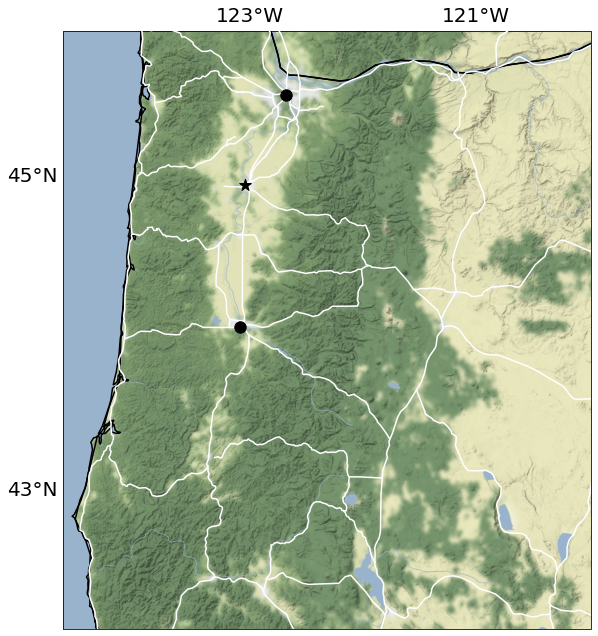

In [20]:
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt

fig = plt.figure(figsize=(10,11))
#ax = plt.axes(projection=ccrs.Mercator())
stamen_terrain = cimgt.Stamen('terrain-background')
ax = plt.axes(projection=stamen_terrain.crs)

figDir = '/uufs/chpc.utah.edu/common/home/u1014509/public_html/phd/zarr/'

ax.coastlines(linewidth=1.5)
ax.set_extent([-124.65,-119.98,42.1,45.9])
states = cartopy.feature.NaturalEarthFeature(
            category='cultural', scale='50m', facecolor='none',
            name='admin_1_states_provinces_shp')

roads = cartopy.feature.NaturalEarthFeature(
            category='cultural', scale='10m', facecolor='none',
            name='roads')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.bottom_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlocator = mticker.FixedLocator([-123,-121])
gl.ylocator = mticker.FixedLocator([43,45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 20, 'color': 'black'}
gl.xlabel_style = {'size': 20,'color': 'black'}



ax.add_image(stamen_terrain,8)
ax.add_feature(states,edgecolor='black',linewidth=1.5,zorder=98)
ax.add_feature(cartopy.feature.BORDERS,edgecolor='black',zorder=98)
ax.add_feature(roads,edgecolor='white',linewidth=1.5,zorder=98)

ax.scatter(-122.6750,45.5051,s=130,c='k',transform=ccrs.PlateCarree(),zorder=99)
ax.scatter(-123.0351,44.9429,s=150,marker='*',c='k',transform=ccrs.PlateCarree(),zorder=99)
ax.scatter(-123.0861,44.0511,s=130,c='k',transform=ccrs.PlateCarree(),zorder=99)

plt.savefig(figDir+'chunkTerrain.pdf')

## Plot Ensemble Probability of Exceedence
### Download Forecast Chunks

In [ ]:
# Set up dates
dates = []
DAY = []

# Set up hourly time stamps
start = datetime(2020, 9, 7, 0, 0)
end = start + timedelta(hours=48)

for times in zplt.perdelta(start, end, timedelta(hours=1)):
    DAY.append(datetime.strftime(times, '%Y%m%d'))
    dates.append(datetime.strftime(times, '%Y%m%d_%Hz'))

In [ ]:
tempFilePath = '/uufs/chpc.utah.edu/common/home/horel-group4/tmccorkle/hrrr_conus/fcst_chunks/'

for hr in range(0,len(dates)):
    
    fileName = dates[hr]+'_fcst.zarr'
    fileKey = 'sfc/'+DAY[hr]+'/'+fileName+levelVar+chunkID
    chunkPath = tempFilePath+dates[hr]+'_chunk'
    s3.meta.client.download_file(BUCKET, fileKey, chunkPath)
 

In [ ]:
tempFilePath = '/uufs/chpc.utah.edu/common/home/horel-group4/tmccorkle/hrrr_conus/fcst_chunks/'

# Valid for 00z 9/8
fhr = [23,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0]
runs = [0,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]


ensembleCount = np.zeros((150,150))

for i in range(0,len(fhr)):
    val = runs[i]
    chunkPath = tempFilePath+dates[val]+'_chunk'
    # Decompress the chunk you want
    buf = ncd.blosc.decompress(open(chunkPath, 'rb').read())

    chunk = np.frombuffer(buf, dtype='<f2')

    if len(chunk) == 810000:
        n = 36
    else:
        n = 18
    
    hrrrVar = np.reshape(chunk,((n,150,150)))
    idx = fhr[i]
    
    hrrrArray = np.zeros((n,150,150))
    hrrrArray[:] = hrrrVar[:]
    
    validTimeFcst = hrrrArray[idx,:,:]
    
    validTimeFcst[validTimeFcst<10] = 0.
    validTimeFcst[validTimeFcst>=10] = 1.
    
    ensembleCount = ensembleCount + validTimeFcst
    
ensembleProb = ensembleCount/19.

In [ ]:
# Valid for 06z 9/8
fhr1 = [29,23,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0]
runs1 = [0,6,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]

ensembleCount1 = np.zeros((150,150))

for i in range(0,len(fhr1)):
    val = runs1[i]
    chunkPath = tempFilePath+dates[val]+'_chunk'
    # Decompress the chunk you want
    buf = ncd.blosc.decompress(open(chunkPath, 'rb').read())

    chunk = np.frombuffer(buf, dtype='<f2')

    if len(chunk) == 810000:
        n = 36
    else:
        n = 18
    
    hrrrVar = np.reshape(chunk,((n,150,150)))
    idx = fhr1[i]
    
    hrrrArray = np.zeros((n,150,150))
    hrrrArray[:] = hrrrVar[:]
    
    validTimeFcst1 = hrrrArray[idx,:,:]
    
    validTimeFcst1[validTimeFcst1<=10] = 0.
    validTimeFcst1[validTimeFcst1>10] = 1.
    
    ensembleCount1 = ensembleCount1 + validTimeFcst1
    
ensembleProb1 = ensembleCount1/20.

In [ ]:
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())

figDir = '/uufs/chpc.utah.edu/common/home/u1014509/public_html/phd/zarr/'

ax.coastlines(linewidth=1.5)
ax.set_extent([-124.95,-119.98,41.98,46.01])
states = cartopy.feature.NaturalEarthFeature(
            category='cultural', scale='50m', facecolor='none',
            name='admin_1_states_provinces_shp')

roads = cartopy.feature.NaturalEarthFeature(
            category='cultural', scale='10m', facecolor='none',
            name='roads')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.bottom_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlocator = mticker.FixedLocator([-124,-122,-120])
gl.ylocator = mticker.FixedLocator([42,43,44,45,46])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 15, 'color': 'black'}
gl.xlabel_style = {'size': 15,'color': 'black'}

clevs = np.arange(0,1.01,.05)
cmap = plt.cm.get_cmap('PuBuGn')
norm = mcolors.BoundaryNorm(clevs,cmap.N)

ax.add_feature(states,edgecolor='black',linewidth=1.5,zorder=98)
ax.add_feature(roads,edgecolor='grey',linewidth=1.5,zorder=98)
ax.add_feature(cartopy.feature.BORDERS,edgecolor='black',zorder=98)

cs = ax.contourf(newLons,newLats,ensembleProb1,clevs,cmap=cmap,
                norm=norm,transform=ccrs.PlateCarree(),zorder=97)

ax.text(0.52, .9, 'Valid 9/8/2020 03 UTC\n Wind Gust > 15 m/s', transform=ax.transAxes, 
        size=20, bbox=dict(facecolor='white', edgecolor='black'),zorder=99)

cb_ax = fig.add_axes([.2,.02,.62,.65],visible=None)
cbar = plt.colorbar(cs,ax=cb_ax,ticks=[0,.2,.4,.6,.8,1.0],orientation='horizontal')
cbar.ax.set_xticklabels(['0','.2','.4','.6','.8','1'], fontsize=15)
cbar.set_label('Probability of Threshold Exceedence',size=20)

#plt.savefig(figDir+'probExceed15_20200908_03z.pdf')

In [ ]:
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt

fig = plt.figure(figsize=(12,8.5))

stamen_terrain = cimgt.Stamen('terrain-background')
ax = plt.subplot(121,projection=stamen_terrain.crs)

clevs = np.arange(0,1.01,.05)
cmap = plt.cm.get_cmap('rainbow')
norm = mcolors.BoundaryNorm(clevs,cmap.N)

figDir = '/uufs/chpc.utah.edu/common/home/u1014509/public_html/phd/zarr/'

states = cartopy.feature.NaturalEarthFeature(
            category='cultural', scale='50m', facecolor='none',
            name='admin_1_states_provinces_shp')

roads = cartopy.feature.NaturalEarthFeature(
            category='cultural', scale='10m', facecolor='none',
            name='roads')

###########

ax.coastlines(linewidth=1.5)
ax.set_extent([-124.65,-119.98,42.1,45.9])

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlocator = mticker.FixedLocator([-123,-121])
gl.ylocator = mticker.FixedLocator([43,45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 20, 'color': 'black'}
gl.xlabel_style = {'size': 20,'color': 'black'}

ax.add_image(stamen_terrain,8)
ax.add_feature(states,edgecolor='black',linewidth=1.5,zorder=98)
ax.add_feature(roads,edgecolor='white',linewidth=1.25,zorder=98)
ax.add_feature(cartopy.feature.BORDERS,edgecolor='black',zorder=98)

ensembleProb[ensembleProb<0.01] = np.nan
cs = ax.contourf(newLons,newLats,ensembleProb,clevs,cmap=cmap,
                norm=norm,transform=ccrs.PlateCarree(),alpha=0.85,zorder=97)

ax.text(0.82, .87, '00 UTC\n9/8/2020', transform=ax.transAxes, ha='center',
        size=16, bbox=dict(facecolor='white', edgecolor='black'),zorder=99)

###########
ax = plt.subplot(122,projection=stamen_terrain.crs)

ax.coastlines(linewidth=1.5)
ax.set_extent([-124.65,-119.98,42.1,45.9])

clevs = np.arange(0,1.01,.05)
cmap = plt.cm.get_cmap('rainbow')
norm = mcolors.BoundaryNorm(clevs,cmap.N)

gl1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl1.bottom_labels = False
gl1.left_labels = False
gl1.xlines = False
gl1.ylines = False
gl1.xlocator = mticker.FixedLocator([-123,-121])
gl1.ylocator = mticker.FixedLocator([43,45])
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.ylabel_style = {'size': 20, 'color': 'black'}
gl1.xlabel_style = {'size': 20,'color': 'black'}

ax.add_image(stamen_terrain,8)
ax.add_feature(states,edgecolor='black',linewidth=1.5,zorder=98)
ax.add_feature(roads,edgecolor='white',linewidth=1.25,zorder=98)
ax.add_feature(cartopy.feature.BORDERS,edgecolor='black',zorder=98)

ensembleProb1[ensembleProb1<0.01] = np.nan
ax.contourf(newLons,newLats,ensembleProb1,clevs,cmap=cmap,
                norm=norm,transform=ccrs.PlateCarree(),alpha=0.85,zorder=97)

ax.text(0.82, .87, '06 UTC\n9/8/2020', transform=ax.transAxes, ha='center',
        size=16, bbox=dict(facecolor='white',edgecolor='black'),zorder=99)
    
    
cb_ax = fig.add_axes([.18,.07,.65,.72],visible=None)
cbar = plt.colorbar(cs,ax=cb_ax,ticks=[0,.2,.4,.6,.8,1.0],orientation='horizontal')
cbar.ax.set_xticklabels(['0','.2','.4','.6','.8','1'], fontsize=16)
cbar.set_label('Probability of Wind Gust > 10 m/s',size=20)

plt.subplots_adjust(wspace=0.03, hspace=0.01)
plt.savefig(figDir+'probExceed_00z_06z.pdf')